In [ ]:
import os
import shutil
import cv2
import albumentations as A
from tqdm import tqdm
from PIL import Image
import numpy as np

import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
# Конфигурация
IMAGES_DIR = "./source_dataset/images"
LABELS_DIR = "./source_dataset/labels"
OUTPUT_IMAGES_DIR = "./augmented/images"
OUTPUT_LABELS_DIR = "./augmented/labels"
TARGET_SIZE = 1024
CROP_PERCENT_1 = 0.6
CROP_PERCENT_2 = 0.75
CENTER_CROP_PERCENT_1 = 0.25
CENTER_CROP_PERCENT_2 = 0.5

os.makedirs(OUTPUT_IMAGES_DIR, exist_ok=True)
os.makedirs(OUTPUT_LABELS_DIR, exist_ok=True)

def get_crop_regions(h, w):
    """Генерация 11 областей для кропа"""
    return [
        (0, 0, w, h),
        # (0, 0, int(w*CROP_PERCENT_1), int(h*CROP_PERCENT_1)),
        # (int(w*(1-CROP_PERCENT_1)), 0, w, int(h*CROP_PERCENT_1)),
        # (0, int(h*(1-CROP_PERCENT_1)), int(w*CROP_PERCENT_1), h),
        # (int(w*(1-CROP_PERCENT_1)), int(h*(1-CROP_PERCENT_1)), w, h),
        (0, 0, int(w*CROP_PERCENT_2), int(h*CROP_PERCENT_2)),
        (int(w*(1-CROP_PERCENT_2)), 0, w, int(h*CROP_PERCENT_2)),
        (0, int(h*(1-CROP_PERCENT_2)), int(w*CROP_PERCENT_2), h),
        (int(w*(1-CROP_PERCENT_2)), int(h*(1-CROP_PERCENT_2)), w, h),
        # (int(w*(0.5-CENTER_CROP_PERCENT_1/2)), int(h*(0.5-CENTER_CROP_PERCENT_1/2)),
        #  int(w*(0.5+CENTER_CROP_PERCENT_1/2)), int(h*(0.5+CENTER_CROP_PERCENT_1/2))),
        # (int(w*(0.5-CENTER_CROP_PERCENT_2/2)), int(h*(0.5-CENTER_CROP_PERCENT_2/2)),
        #  int(w*(0.5+CENTER_CROP_PERCENT_2/2)), int(h*(0.5+CENTER_CROP_PERCENT_2/2)))
    ]

def generate_crops(image, bboxes, class_ids):
    """Генерация 5 кропов изображения"""
    crops = []
    for crop_idx, (x1, y1, x2, y2) in enumerate(get_crop_regions(*image.shape[:2])):
        transform = A.Compose([
            A.Crop(x1, y1, x2, y2),
            A.Resize(TARGET_SIZE, TARGET_SIZE, interpolation=cv2.INTER_LANCZOS4)
        ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_ids']))
        
        transformed = transform(image=image.copy(), bboxes=bboxes.copy(), class_ids=class_ids.copy())
        crops.append((transformed['image'], transformed['bboxes'], transformed['class_ids'], crop_idx))
    return crops

def apply_rotations(image, bboxes, class_ids):
    """Применение 3 поворотов по 120 градусов"""
    rotations = []
    for angle in range(0, 360, 120):
        transform = A.Compose([
            A.Rotate(limit=(angle, angle), p=1, border_mode=cv2.BORDER_CONSTANT, interpolation=cv2.INTER_LANCZOS4),
            A.LongestMaxSize(max_size=TARGET_SIZE, interpolation=cv2.INTER_LANCZOS4),
            A.PadIfNeeded(min_height=TARGET_SIZE, min_width=TARGET_SIZE, border_mode=cv2.BORDER_CONSTANT, value=0)
        ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_ids']))
        
        transformed = transform(image=image.copy(), bboxes=bboxes.copy(), class_ids=class_ids.copy())
        rotations.append((transformed['image'], transformed['bboxes'], transformed['class_ids'], angle))
    return rotations

def apply_flips(image, bboxes, class_ids):
    """Применение 1 варианта отражений"""
    flips = []
    for flip_type in ['none']: # ['none', 'horizontal', 'vertical', 'both']:
        transforms = []
        if 'horizontal' in flip_type:
            transforms.append(A.HorizontalFlip(p=1))
        if 'vertical' in flip_type:
            transforms.append(A.VerticalFlip(p=1))
        
        transform = A.Compose(
            transforms,
            bbox_params=A.BboxParams(format='yolo', label_fields=['class_ids'])
        )
        
        transformed = transform(image=image.copy(), bboxes=bboxes.copy(), class_ids=class_ids.copy())
        flips.append((transformed['image'], transformed['bboxes'], transformed['class_ids'], flip_type))
    return flips

def save_result(image, bboxes, class_ids, base_name, suffixes):
    """Сохранение результата с комбинированным суффиксом"""
    suffix = "_".join(suffixes)
    image_path = os.path.join(OUTPUT_IMAGES_DIR, f"{base_name}{suffix}.jpg")
    label_path = os.path.join(OUTPUT_LABELS_DIR, f"{base_name}{suffix}.txt")
    
    cv2.imwrite(image_path, image, [cv2.IMWRITE_JPEG_QUALITY, 100])
    
    with open(label_path, 'w') as f:
        for cls, bbox in zip(class_ids, bboxes):
            f.write(f"{int(cls)} {' '.join(map(str, bbox))}\n")

# Основной цикл обработки
for label_file in tqdm(os.listdir(LABELS_DIR)):
    if not label_file.endswith('.txt'):
        continue
    
    base_number = os.path.splitext(label_file)[0]
    image_path = next((os.path.join(IMAGES_DIR, f"{base_number}{ext}") 
                      for ext in ['.jpg', '.png', '.jpeg', '.tif'] 
                      if os.path.exists(os.path.join(IMAGES_DIR, f"{base_number}{ext}"))), None)
    
    if not image_path:
        print(f"Изображение для {base_number} не найдено")
        continue

    # Загрузка данных
    image = cv2.imread(image_path)
    with open(os.path.join(LABELS_DIR, label_file)) as f:
        lines = [list(map(float, line.strip().split())) for line in f]
    
    class_ids = [int(line[0]) for line in lines]
    original_bboxes = [line[1:] for line in lines]

    # Обработка кропов
    for cropped_image, cropped_bboxes, cropped_class_ids, crop_idx in generate_crops(image, original_bboxes, class_ids):
        # Обработка поворотов
        for rotated_image, rotated_bboxes, rotated_class_ids, angle in apply_rotations(cropped_image, cropped_bboxes, cropped_class_ids):
            # Обработка отражений
            for flipped_image, flipped_bboxes, flipped_class_ids, flip_type in apply_flips(rotated_image, rotated_bboxes, rotated_class_ids):
                suffixes = [
                    f"crop{crop_idx}",
                    f"rot{angle}",
                    f"flip{flip_type}"
                ]
                save_result(flipped_image, flipped_bboxes, flipped_class_ids, base_number, suffixes)

  0%|          | 0/887 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_18300\136363049.py:53: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=TARGET_SIZE, min_width=TARGET_SIZE, border_mode=cv2.BORDER_CONSTANT, value=0)
d:\Projects\DETAIR\.venv\Lib\site-packages\albumentations\core\composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
100%|██████████| 887/887 [07:29<00:00,  1.97it/s]


In [6]:
def split_dataset(output_dir, images_dir, labels_dir, ratios=(0.8, 0.1, 0.1)):
    # Собираем все файлы изображений
    image_files = [f for f in os.listdir(images_dir) 
                 if f.lower().endswith(('.jpg', '.jpeg'))]
    
    # Проверяем соответствие меток
    paired_data = []
    for img_file in image_files:
        base_name = os.path.splitext(img_file)[0]
        label_file = f"{base_name}.txt"
        label_path = os.path.join(labels_dir, label_file)
        
        if os.path.exists(label_path):
            paired_data.append((img_file, label_file))
        else:
            print(f"⚠️ Отсутствует метка для {img_file}, пропускаем")

    # Перемешиваем данные
    random.seed(42)
    random.shuffle(paired_data)

    # Рассчитываем границы разделения
    total = len(paired_data)
    train_end = int(total * ratios[0])
    val_end = train_end + int(total * ratios[1])

    # Разделяем данные
    train_data = paired_data[:train_end]
    val_data = paired_data[train_end:val_end]
    test_data = paired_data[val_end:]

    # Создаем структуру папок
    splits = {
        'train': train_data,
        'val': val_data,
        'test': test_data
    }

    for split_name, data in splits.items():
        # Создаем директории
        os.makedirs(os.path.join(output_dir, split_name, 'images'), exist_ok=True)
        os.makedirs(os.path.join(output_dir, split_name, 'labels'), exist_ok=True)

        # Копируем файлы
        for img_file, label_file in data:
            # Копируем изображение
            shutil.copy(
                os.path.join(images_dir, img_file),
                os.path.join(output_dir, split_name, 'images', img_file)
            )
            # Копируем метку
            shutil.copy(
                os.path.join(labels_dir, label_file),
                os.path.join(output_dir, split_name, 'labels', label_file)
            )

    # Выводим статистику
    print("Разделение завершено:")
    print(f"Всего элементов: {total}")
    print(f"Train: {len(train_data)} ({len(train_data)/total:.1%})")
    print(f"Val: {len(val_data)} ({len(val_data)/total:.1%})")
    print(f"Test: {len(test_data)} ({len(test_data)/total:.1%})")

# Использование
OUTPUT_IMAGES_DIR = "./augmented/images"
OUTPUT_LABELS_DIR = "./augmented/labels"
OUTPUT_ROOT = "./YOLO_detected"

split_dataset(
    output_dir=OUTPUT_ROOT,
    images_dir=OUTPUT_IMAGES_DIR,
    labels_dir=OUTPUT_LABELS_DIR
)

Разделение завершено:
Всего элементов: 13305
Train: 10644 (80.0%)
Val: 1330 (10.0%)
Test: 1331 (10.0%)


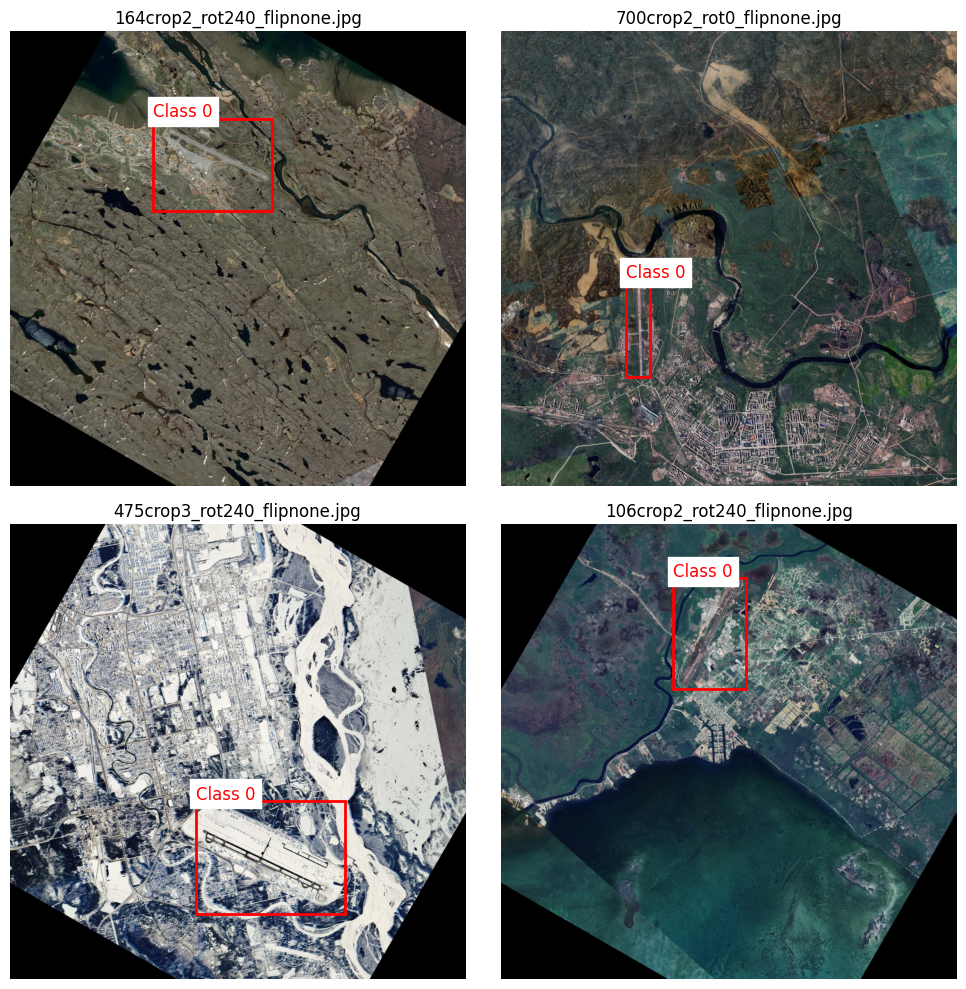

In [12]:
OUTPUT_IMAGES_DIR = "./YOLO_detected/train/images"
OUTPUT_LABELS_DIR = "./YOLO_detected/train/labels"

def plot_augmented_samples(num_samples=4):
    # Получаем список всех аугментированных изображений
    all_images = [f for f in os.listdir(OUTPUT_IMAGES_DIR) if f.endswith('.jpg')]
    
    # Выбираем случайные 4 образцов
    selected_images = random.sample(all_images, min(num_samples, len(all_images)))
    
    # Создаем сетку для отображения
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.ravel()
    
    for idx, img_name in enumerate(selected_images):
        # Загрузка изображения
        img_path = os.path.join(OUTPUT_IMAGES_DIR, img_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Загрузка аннотаций
        label_path = os.path.join(OUTPUT_LABELS_DIR, img_name.replace('.jpg', '.txt'))
        if not os.path.exists(label_path):
            print(f"Annotation missing for {img_name}")
            continue
            
        with open(label_path, 'r') as f:
            annotations = [line.strip().split() for line in f]
        
        # Отрисовка bounding boxes
        ax = axes[idx]
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(os.path.basename(img_name))
        
        for ann in annotations:
            if len(ann) != 5:
                print(f"Invalid annotation in {img_name}: {ann}")
                continue
                
            class_id, x_center, y_center, width, height = map(float, ann)
            
            # Конвертация YOLO в абсолютные координаты
            img_h, img_w = image.shape[:2]
            x = (x_center - width/2) * img_w
            y = (y_center - height/2) * img_h
            w = width * img_w
            h = height * img_h
            
            # Рисуем прямоугольник
            rect = patches.Rectangle(
                (x, y), w, h,
                linewidth=2,
                edgecolor='r',
                facecolor='none'
            )
            ax.add_patch(rect)
            
            # Подпись класса
            ax.text(x, y-5, f'Class {int(class_id)}', color='red', fontsize=12, backgroundcolor='white')
    
    plt.tight_layout()
    plt.show()

# Запуск проверки
plot_augmented_samples()